# Sentiment Analysis Using Huggingface

Unstructured Data - Think video, audio, images, and big chunks of text. It's anything that doesn't neatly fit into a database or a spreadsheet in neat rows and columns. It's the messy kind of data that humans generate as easily as we breathe.

What's Deep Learning? - Just machine learning based on artificial neural networks in which multiple layers of processing are used to extract progressively higher level features from data.

In this project, we will fine-tune pre-trained Deep Learning models from HuggingFace on a new dataset to adapt the models to the task that we want to solve, then create an app to use the models and deploy the app on the HuggingFace platform.

### Install Libraries and Packages

In [1]:
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

### Import Libraries and Packages

In [2]:
#System and data handling
import os
import re
import warnings
import pandas as pd
import numpy as np

#Data Analysis & Preparation
from evaluate import load
from collections import Counter
from datasets import load_dataset

#Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

#Google Drive
from google.colab import drive

#Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, TFAutoModelForSequenceClassification

#Scores
from scipy.special import softmax

# Deep learning
import torch
from torch import nn

#Huggingface
from huggingface_hub import notebook_login

### Setup

In [3]:
# Set a fixed random seed for PyTorch on CPU
torch.manual_seed(42)

# Control the seed for individual GPU operations (optional)
if torch.cuda.is_available:
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed_all(42)


In [4]:
# Connect to your google drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set CUDA_LAUNCH_BLOCKING for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### Data Loading

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/Coachella-2015-2-DFE.csv', encoding='latin-1')

In [7]:
#look at first 10 rows in train data
df.tail()

,coachella_sentiment,coachella_yn,name,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
3841,cant tell,yes,MissXOverdose,0,Excuse me while I go cry now. _Ù÷¢ #Coachella2...,NaN,1/6/15 10:32,5.525330e+17,atx,Pacific Time (US & Canada)
3842,cant tell,yes,NedRaggett,1,RT @touchofallright: Ride and Steely Dan. It w...,NaN,1/6/15 10:28,5.525320e+17,"Costa Mesa, CA",Pacific Time (US & Canada)
3843,cant tell,yes,nicolejackieee,0,I've been callin that since day one #Coachella...,NaN,1/6/15 10:26,5.525320e+17,NaN,NaN
3844,cant tell,yes,NiqueWobbitz,2,Is this for real?!?! #Coachella2015 http://t.c...,NaN,1/6/15 10:21,5.525300e+17,Huntington Beach X Long Beach,Pacific Time (US & Canada)
3845,cant tell,yes,LindsayRuben,1,RT @Jen_Baz: C'monnnnnn lineup! #coachella2015...,NaN,1/6/15 6:44,5.524760e+17,NaN,NaN


In [8]:
df = df.drop(columns=['coachella_yn', 'name', 'retweet_count', 'tweet_coord', 'tweet_id', 'user_timezone','tweet_location', 'tweet_created'])
df.head(10)

,coachella_sentiment,text
0,positive,#Coachella2015 tickets selling out in less tha...
1,positive,RT @sudsybuddy: WAIT THIS IS ABSOLUTE FIRE _ÙÓ...
2,positive,#Coachella2015 #VIP passes secured! See you th...
3,positive,PhillyÛªs @warondrugsjams will play #Coachell...
4,positive,If briana and her mom out to #Coachella2015 i...
5,positive,West side is the best side!\n#west #coas #Coac...
6,positive,Coachella tickets are now sold out _Ù÷_ &amp; ...
7,positive,#Coachella2015 I absolutely can NOT wait. This...
8,positive,If someone got me to Coachella if be your frie...
9,positive,RT @brownjenjen:  Õ http://t.co/mxCREvIlGP 71...


In [9]:
df.shape

(3846, 2)

In [10]:
df.dtypes

,0
coachella_sentiment,object
text,object


In [11]:
df.describe()

,coachella_sentiment,text
count,3846,3846
unique,4,3846
top,positive,RT @Jen_Baz: C'monnnnnn lineup! #coachella2015...
freq,2283,1


In [12]:
df.isna().sum()

,0
coachella_sentiment,0
text,0


In [13]:
df.rename(columns={'coachella_sentiment': 'label'}, inplace=True)

In [14]:
df.label.value_counts()

,count
label,
positive,2283
neutral,928
negative,553
cant tell,82


In [15]:
df.text.sample(10)

,text
1615,#Coachella2015 baby
1891,can't wait for #Coachella2015 https://t.co/7Wy...
2242,My savings account has been waiting for this m...
1250,I can't deal with looking down my TL too depre...
3588,"I know it's no longer about the music,but am I..."
1421,"If the lineup is out, itÛªs never too soon to..."
266,So fucking amped _Ù÷__Ù÷_ #Coachella2015 http:...
1641,RT @rosaontherocks: I literally can't with thi...
2931,Is steely Dan gonna be hologram? #Coachella2015
1055,west coast woodstock aka @coachella countdown ...


## Data Preparation

1. Remove rows with *'can't tell'* sentiment values.
2. Clean *safe-text* column of Twitter Handles, HTML characters, URLs and other non alphabetic characters. Text is inconsistent and may affect model performance.



In [16]:
df = df[df['label'] != 'cant tell']

In [17]:
df.label.value_counts()

,count
label,
positive,2283
neutral,928
negative,553


In [18]:
def clean_text(text):
    # Convert text to lower case
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove tweet mentions
    text = re.sub(r'<user>', '', text)
    text = re.sub(r'<url>', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Replace all whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing whitespace
    text = text.strip()

    return text

In [19]:
# Apply the clean_text function to the 'safe_text' column
df['text'] = df.text.apply(clean_text)

In [20]:
df.sample(10)

,label,text
2128,positive,jackjanaszek lineup is pretty solid gonna see ...
3591,negative,rt thebightonight hmm buy tickets to coachella...
2169,positive,steely dan drake sbtrkt toro y moi acdc flying...
3451,negative,i dont get it why isnt miauniverse on this lis...
1600,positive,coachella woaaahhhhh
797,positive,cannot wait to blog my coachella vip experienc...
585,positive,im going to keep talking about coachella idc i...
608,positive,amazing days in april see you there again coac...
1371,positive,dang coachella i have to get tickets asap
1445,positive,the second weekend of coachella is the weekend...


In [21]:
df.label.value_counts()

,count
label,
positive,2283
neutral,928
negative,553


In [22]:
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}

# Map the sentiment labels to numerical values
df['label'] = df['label'].map(sentiment_mapping)

In [23]:
df.label.value_counts()

,count
label,
1,2283
0,928
-1,553


### Exploratory Data Analysis

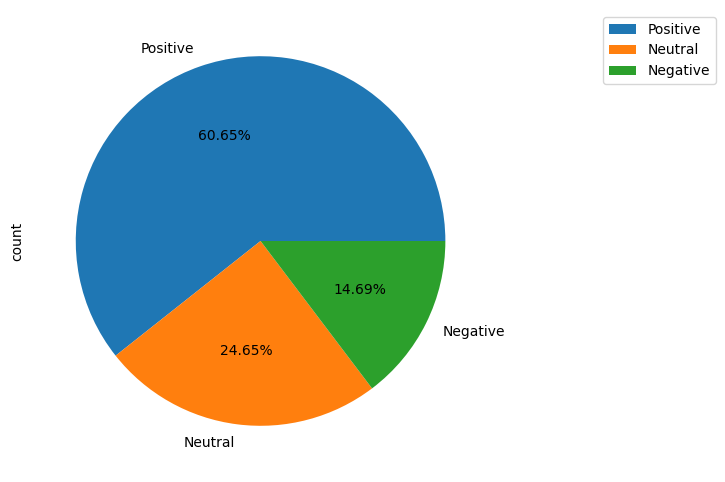

In [24]:
# pie chart wth 'labels' column
plt.figure(figsize=(6,6))
explode=0.1,0
df.label.value_counts().plot.pie(autopct='%1.2f%%',labels=['Positive','Neutral','Negative'])
plt.legend(bbox_to_anchor=(1.5,1))
plt.show()

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

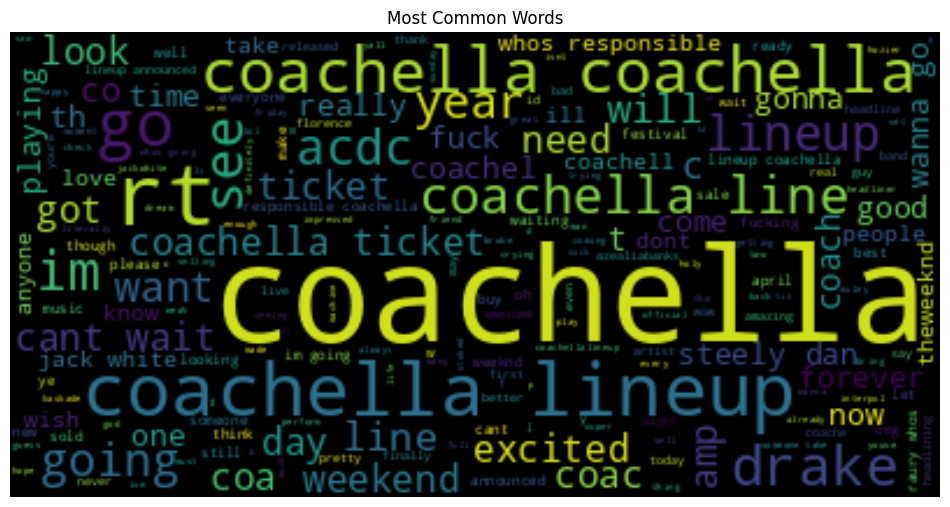

In [25]:
# Word Cloud
all_data = df['text'].to_string()
wordcloud = WordCloud().generate(all_data)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('Most Common Words')
plt.axis("off")

In [26]:
# Word Count
temp_list = df['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in temp_list for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,coachella,4854
1,to,1356
2,the,1298
3,i,955
4,lineup,725
5,is,721
6,and,573
7,rt,518
8,for,513
9,this,426


In [27]:
text_lengths = df['text'].str.split().str.len()
text_lengths.value_counts().sort_values(ascending=False)

,count
text,
7,310
6,263
9,262
5,256
10,246
8,243
12,212
13,210
11,201


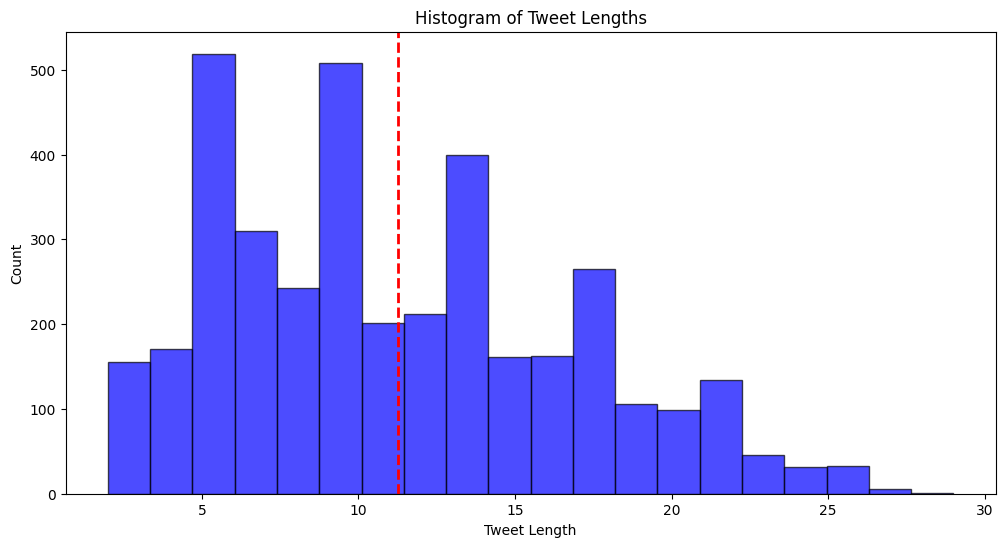

In [28]:
# Calculate the average
average_length = np.mean(text_lengths)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Using plt.hist to create a histogram with Matplotlib
ax.hist(text_lengths, bins=20, color="blue", edgecolor="black", alpha=0.7)

# Add average line
ax.axvline(average_length, color='red', linestyle='dashed', linewidth=2, label=f'Average: {average_length:.2f}')

ax.set_title('Histogram of Tweet Lengths')
ax.set_xlabel('Tweet Length')
ax.set_ylabel('Count')

# Display the plot
plt.show()

### Train Test Split

In [29]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [30]:
train.head()

,label,text
3469,-1,i wish incubus or sonsofthesea would have been...
2956,0,eric this is hilareous haha thatericalper this...
3584,-1,gotta get my abs back for coachella but i love...
3296,-1,i hope it rains during drakes coachella set so...
1011,1,omg the coachella lineup soexcited


In [31]:
eval.head()

,label,text
1576,1,everyone is talking about the nflplayoffs and ...
3577,-1,ok back to oogling and crying at this lineup t...
726,1,bring it coachella have my artist pass amp roo...
3197,0,coachella lineup preview coachella coachella c...
1,1,rt sudsybuddy wait this is absolute fire coach...


In [32]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (3011, 2), eval is (753, 2)


In [33]:
# Save split subsets
train.to_csv("/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/train_subset.csv", index=False)
eval.to_csv("/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/eval_subset.csv", index=False)

In [34]:
# Load split subsets

dataset = load_dataset('csv',
                        data_files={'train': '/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/train_subset.csv',
                        'eval': '/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/eval_subset.csv'}, encoding = "ISO-8859-1")

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

## Model Fine Tuning and Training

In [35]:
#login to huggingface with access token

notebook_login()

In [36]:
warnings.filterwarnings("ignore", category=FutureWarning)

nlp = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(nlp)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [37]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

In [38]:
# Function to tokenize data

def tokenize_data(example):
    return tokenizer(example['text'], padding=True, max_length = 'max_length')

In [39]:
# Change the tweets to tokens that the model can use
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['label', 'text']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/3011 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/3011 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

In [40]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3011
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 753
    })
})

#### Balancing Target Classes

Since our target has imbalanced class weights (positive, neutral and negative dont have an equal number of samples), we want to give more weight to underrepresented classes and give less weight to classes with more samples.

In [41]:
# Define the labels
labels = dataset['train']['labels']

# Apply the compute class weight function to calculate the class weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

The `balanced` option in compute_class_weight will calculate weights such that the classes are balanced.

In [42]:
# Preview class weights
class_weights, np.unique(labels)

(array([2.26561324, 1.35265049, 0.54965316]), array([0, 1, 2]))

In [43]:
# Define an instance of the pre-trained model with the number of labels
model = AutoModelForSequenceClassification.from_pretrained(nlp, num_labels=3)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
# Configure the training parameters

training_args = TrainingArguments("Coachella_sentiment_analysis_roberta",
    num_train_epochs=5, # the number of times the model will repeat the training loop over the dataset
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',)

In [45]:
# evaluation metrics
metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [46]:
# Instantiate the training and validation sets with random state of 10
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

In [47]:
# Convert train data to PyTorch tensors to speed up training and add padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,padding=True, max_length='max_length', return_tensors='pt')

In [48]:
# Define Custom Trainer | Modify loss function and assign computed weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Ensure logits and labels have compatible shapes
        assert logits.shape[1] == self.model.config.num_labels, f"Logits shape {logits.shape} does not match number of labels {self.model.config.num_labels}"
        assert labels.max() < self.model.config.num_labels, f"Labels contain values outside the valid range: {labels}"

        # Ensure labels are of integer type
        assert labels.dtype == torch.long, f"Labels must be of type torch.long, but got {labels.dtype}"

        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(model.device)

        # Compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [49]:
# Instantiate the trainer for training
c_trainer = CustomTrainer(
                  model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  tokenizer = tokenizer,
                  compute_metrics=compute_metrics,
)

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [50]:
# Launch the learning process: training
c_trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: obandoandrew8 (obandoandrew8-unbrick-marketing-hub) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.782570,0.662683
2,0.818000,0.924398,0.719788
3,0.557400,1.296682,0.727756
4,0.349200,1.704545,0.730412
5,0.349200,1.876987,0.737052


TrainOutput(global_step=1885, training_loss=0.5002391825304108, metrics={'train_runtime': 381.4348, 'train_samples_per_second': 39.469, 'train_steps_per_second': 4.942, 'total_flos': 340089509215260.0, 'train_loss': 0.5002391825304108, 'epoch': 5.0})

In [51]:
# Launch the final evaluation
c_trainer.evaluate()

{'eval_loss': 0.7825696468353271,
 'eval_accuracy': 0.6626826029216467,
 'eval_runtime': 3.4111,
 'eval_samples_per_second': 220.75,
 'eval_steps_per_second': 27.85,
 'epoch': 5.0}

In [52]:
# Push model and tokenizer to HF Hub
model.push_to_hub("Azie88/Coachella_sentiment_analysis_roberta")
tokenizer.push_to_hub("Azie88/Coachella_sentiment_analysis_roberta")
dataset.push_to_hub("Azie88/Coachella_sentiment_analysis_roberta")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/453 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Azie88/Coachella_sentiment_analysis_roberta/commit/f8a1b1b195afe7aee0350236ca4e9fb3b4ab7e99', commit_message='Upload dataset', commit_description='', oid='f8a1b1b195afe7aee0350236ca4e9fb3b4ab7e99', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Azie88/Coachella_sentiment_analysis_roberta', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Azie88/Coachella_sentiment_analysis_roberta'), pr_revision=None, pr_num=None)

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

## Inference
Let's test out our model with with some sample text

In [53]:
model_path = f"Azie88/Coachella_sentiment_analysis_roberta"

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/893 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [54]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [55]:
# Input preprocessing
text = "that saturday lineup is fire, except for Jack White"
text = preprocess(text)

In [56]:
# PyTorch-based models
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [57]:
print("Scores:", scores)
print("id2label Dictionary:", config.id2label)

Scores: [0.15121618 0.11940656 0.7293773 ]
id2label Dictionary: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [58]:
config.id2label = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

In [59]:
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) POSITIVE 0.7294
2) NEGATIVE 0.1512
3) NEUTRAL 0.1194
